# Bayesian NN 1D 1 hole

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

import numpy as np 
import pandas as pd 
from scipy import linalg
import matplotlib.pyplot as plt


In [2]:
two_composite_filtered = pd.read_csv("Curated_data/two_composite_filtered.csv", low_memory=False)

- Iteration 0, MSE : 1.19, KL : 10.77
- Iteration 100, MSE : 0.17, KL : 6.27
- Iteration 200, MSE : 0.39, KL : 5.27
- Iteration 300, MSE : 0.11, KL : 4.51
- Iteration 400, MSE : 0.17, KL : 3.93
- Iteration 500, MSE : 0.14, KL : 3.48
- Iteration 600, MSE : 0.04, KL : 3.10
- Iteration 700, MSE : 0.03, KL : 2.78
- Iteration 800, MSE : 0.03, KL : 2.48
- Iteration 900, MSE : 0.03, KL : 2.26
- Iteration 1000, MSE : 0.03, KL : 2.03
- Iteration 1100, MSE : 0.03, KL : 1.82
- Iteration 1200, MSE : 0.04, KL : 1.65
- Iteration 1300, MSE : 0.04, KL : 1.51
- Iteration 1400, MSE : 0.05, KL : 1.39
- Iteration 1500, MSE : 0.04, KL : 1.25
- Iteration 1600, MSE : 0.04, KL : 1.18
- Iteration 1700, MSE : 0.03, KL : 1.08
- Iteration 1800, MSE : 0.03, KL : 0.98
- Iteration 1900, MSE : 0.03, KL : 0.95
- Iteration 2000, MSE : 0.04, KL : 0.89
- Iteration 2100, MSE : 0.03, KL : 0.82
- Iteration 2200, MSE : 0.03, KL : 0.79
- Iteration 2300, MSE : 0.03, KL : 0.77
- Iteration 2400, MSE : 0.04, KL : 0.75
- Iteration

<Figure size 1400x800 with 0 Axes>

Text(0.5, 1.0, 'KV-NME001')

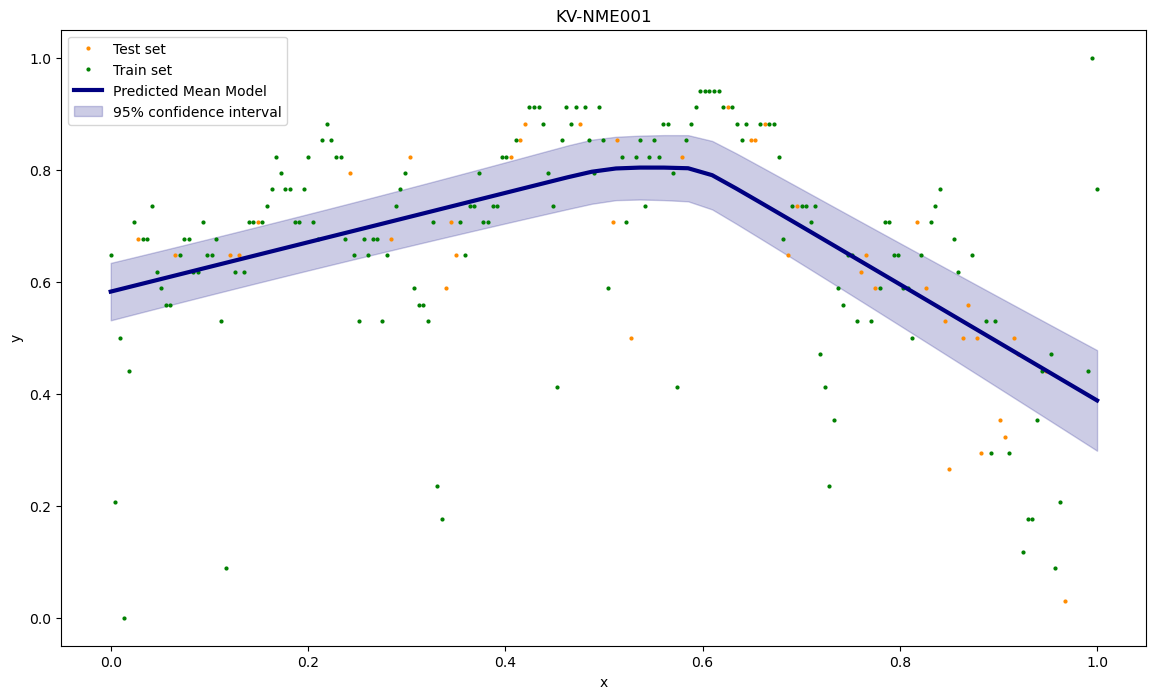

In [15]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])

hole = 'KV-NME001'

two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]


# Calculate the mean and standard deviation for the mineral column
mean_value = two_composite_1mineral_1hole[mineral].mean()
std_dev = two_composite_1mineral_1hole[mineral].std()

# Define a threshold for values to be removed (4 standard deviations from the mean)
threshold = 2 * std_dev

# Remove rows where the mineral values are above the threshold
two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to your data and transform the specified columns
two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
x = x.reshape(len(two_composite_1mineral_1hole),3)
x = x[:,2].reshape(-1,1)

x = torch.tensor(x)
y = torch.tensor(y)
x = x.to(torch.float32)
y = y.to(torch.float32)

# Determine the size of the test set (e.g., 20% of the data)
test_size = int(0.2 * len(x))

# Generate random indices for the test set
test_indices = np.random.choice(len(x), size=test_size, replace=False)

# Create train and test sets based on the indices
x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

x_test = x[np.sort(test_indices)]
y_test = y[np.sort(test_indices)]

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=200),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=1)
)

mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

for step in range(5001):
    pre = model(x_train)
    mse = mse_loss(pre, y_train)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print('- Iteration %d, MSE : %2.2f, KL : %2.2f' % (step, mse.item(), kl.item()))



#models_result = np.array([model(x_test).data.numpy() for k in range(1000)])
original_tensor = torch.linspace(0, 1, len(x_test))

# Reshape it to (170, 1)
reshaped_tensor = original_tensor.view(len(x_test), 1)
models_result = np.array([model(reshaped_tensor).data.numpy() for k in range(1000)])

models_result = models_result[:,:,0]    
models_result = models_result.T
mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
std_values = np.array([models_result[i].std() for i in range(len(models_result))])

plt.figure(figsize=(14,8))
#plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')


plt.plot(reshaped_tensor.data.numpy()[:,0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
plt.fill_between(reshaped_tensor.data.numpy()[:,0] ,mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title(hole)

## Comparison to other methods

c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


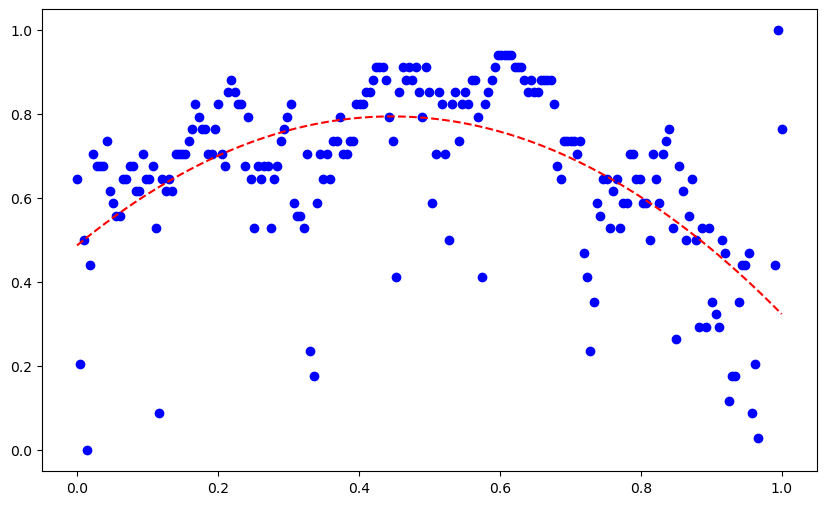

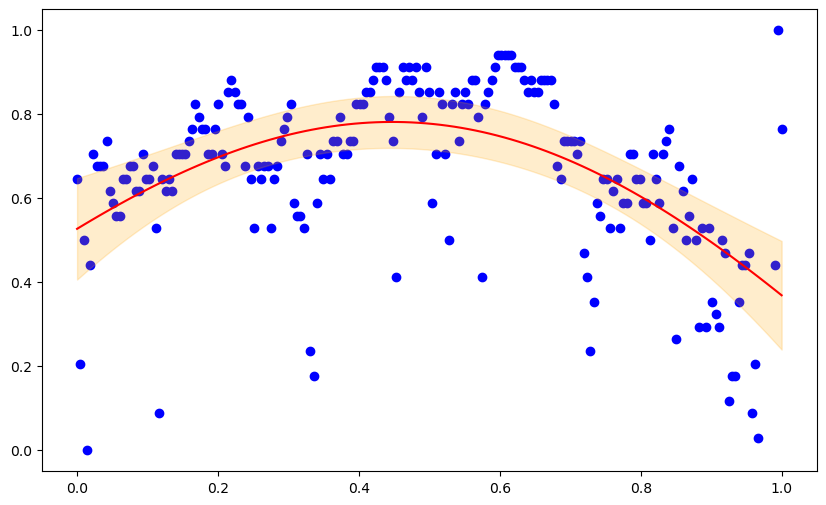

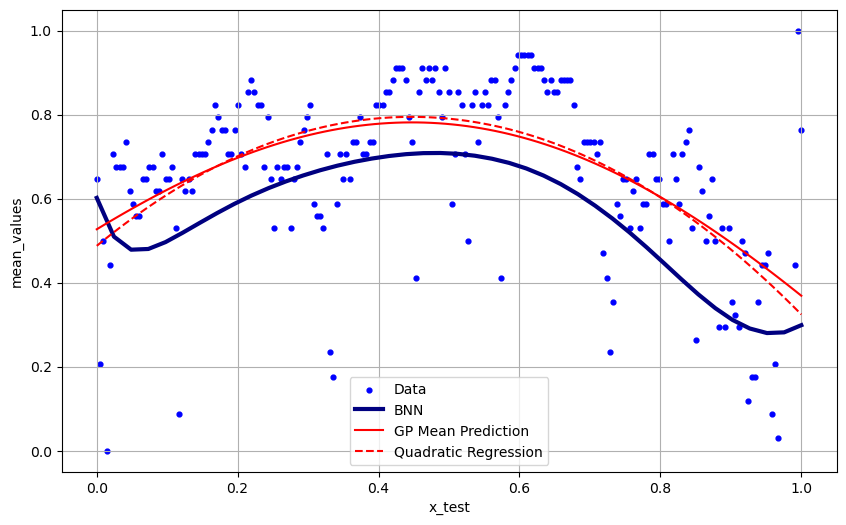

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

x = two_composite_1mineral_1hole['Z'].values
y = two_composite_1mineral_1hole[mineral].values

# Fit a quadratic regression (2nd-degree polynomial)
coefficients = np.polyfit(x, y, 2)

# Create the quadratic regression curve
x_regression = np.linspace(min(x), max(x), 100)  # Generate x values for the regression curve
y_regression = np.polyval(coefficients, x_regression)

# Plot the data points and the regression curve
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(x_regression, y_regression, label='Quadratic Regression', color='red', linestyle='--')


# Assuming you have already sorted your DataFrame by 'x_test' if necessary
x = two_composite_1mineral_1hole['Z'].values.reshape(-1,1)
y = two_composite_1mineral_1hole[mineral].values

# Define a more regularized kernel (RBF kernel with a larger length scale and smaller amplitude)
kernel = C(1, (1e-2, 1e1)) * RBF(10,  (1e0, 1e8))

# Create the GP regression model with regularization
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=10)

# Fit the GP model to the data
gp.fit(x, y)

# Predict with the GP model
x_pred = np.linspace(min(x), max(x), 100).reshape(-1, 1)  # Generate x values for prediction
y_pred, sigma = gp.predict(x_pred, return_std=True)

# Plot the data points, GP mean prediction, and uncertainty
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='blue')
plt.plot(x_pred, y_pred, label='GP Mean Prediction', color='red')
plt.fill_between(x_pred.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='orange', label='95% Confidence Interval')



plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Data', color='blue', s = 12)
plt.plot(reshaped_tensor.data.numpy()[:, 0],mean_values,color='navy',lw=3,label='BNN')
plt.plot(x_pred, y_pred, label='GP Mean Prediction', color='red')
plt.plot(x_regression, y_regression, label='Quadratic Regression', color='red', linestyle='--')
plt.xlabel('x_test')
plt.ylabel('mean_values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mineral = 'Density_gcm3'
two_composite_1mineral = two_composite_filtered.loc[:,["Name", 'X', 'Y', 'Z', mineral]]
two_composite_1mineral = two_composite_1mineral.dropna(subset=[mineral])
for hole in two_composite_filtered['Name'].unique(): 
    two_composite_1mineral_1hole = two_composite_1mineral.loc[two_composite_1mineral['Name'] == hole]
    if len(two_composite_1mineral_1hole) < 100:
        continue
    
    # Calculate the mean and standard deviation for the mineral column
    mean_value = two_composite_1mineral_1hole[mineral].mean()
    std_dev = two_composite_1mineral_1hole[mineral].std()

    # Define a threshold for values to be removed (4 standard deviations from the mean)
    threshold = 2 * std_dev

    # Remove rows where the mineral values are above the threshold
    two_composite_1mineral_1hole = two_composite_1mineral_1hole[abs(two_composite_1mineral_1hole[mineral] - mean_value) <= threshold]    

    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Fit the scaler to your data and transform the specified columns
    two_composite_1mineral_1hole[['Z', mineral]] = scaler.fit_transform(two_composite_1mineral_1hole[['Z', mineral]])



    two_composite_1mineral_1hole=two_composite_1mineral_1hole.sort_values(by='Z')

    x = two_composite_1mineral_1hole[['X','Y', 'Z']].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    y = two_composite_1mineral_1hole[mineral].values[:,np.newaxis] #[:,np.newaxis] makes the second dimension explicit
    x = x.reshape(len(two_composite_1mineral_1hole),3)
    x = x[:,2].reshape(-1,1)

    x = torch.tensor(x)
    y = torch.tensor(y)
    x = x.to(torch.float32)
    y = y.to(torch.float32)

    # Determine the size of the test set (e.g., 20% of the data)
    test_size = int(0.2 * len(x))

    # Generate random indices for the test set
    test_indices = np.random.choice(len(x), size=test_size, replace=False)

    # Create train and test sets based on the indices
    x_train = x[np.setdiff1d(np.arange(len(x)), test_indices)]
    y_train = y[np.setdiff1d(np.arange(len(y)), test_indices)]

    x_test = x[np.sort(test_indices)]
    y_test = y[np.sort(test_indices)]

    model = nn.Sequential(
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.08, in_features=1, out_features=4000),
        nn.ReLU(),
        bnn.BayesLinear(prior_mu=0, prior_sigma=0.08, in_features=4000, out_features=1)
    )

    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.01

    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for step in range(2000):
        pre = model(x_train)
        mse = mse_loss(pre, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight*kl
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
    #print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

    

    #models_result = np.array([model(x_test).data.numpy() for k in range(1000)])
    original_tensor = torch.linspace(0, 1, len(x_test))

    # Reshape it to (170, 1)
    reshaped_tensor = original_tensor.view(len(x_test), 1)
    models_result = np.array([model(reshaped_tensor).data.numpy() for k in range(1000)])

    models_result = models_result[:,:,0]    
    models_result = models_result.T
    mean_values = np.array([models_result[i].mean() for i in range(len(models_result))])
    std_values = np.array([models_result[i].std() for i in range(len(models_result))])

    plt.figure(figsize=(14,8))
    #plt.scatter(x.data.numpy(), y.data.numpy(), s=4)
    plt.show()

    plt.figure(figsize=(14,8))
    plt.plot(x_test.data.numpy()[:,0],y_test.data.numpy()[:,0],'.',color='darkorange',markersize=4,label='Test set')
    plt.plot(x_train.data.numpy()[:,0],y_train.data.numpy()[:,0],'.',color='green',markersize=4,label='Train set')


    plt.plot(reshaped_tensor.data.numpy()[:,0],mean_values,color='navy',lw=3,label='Predicted Mean Model')
    plt.fill_between(reshaped_tensor.data.numpy()[:,0] ,mean_values-2.0*std_values,mean_values+2.0*std_values,alpha=0.2,color='navy',label='95% confidence interval')

    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(hole)